# Data Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd

PATH_CSV = '/kaggle/input/applications-of-deep-learning-wustlfall-2022/beach_demand_forecast/'
PATH_CAM = '/kaggle/input/applications-of-deep-learning-wustlfall-2022/beach_demand_forecast/cam/'

df_sales_train = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_sales_test = pd.read_csv(os.path.join(PATH_CSV,"sales_test.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))

df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce') 
df_sales_test.date = pd.to_datetime(df_sales_test.date, errors='coerce') 

In [2]:
df_sales = pd.concat([df_sales_train, df_sales_test])
df_sales.columns = ['date','item_id','price','sales','submit_id']
df_sales.loc[~df_sales.submit_id.isna(),'submit_id'] = df_sales[~df_sales.submit_id.isna()].submit_id.astype(int)

In [3]:
df_sales

,date,item_id,price,sales,submit_id
0,2019-01-01,3,29.22,2.0,NaN
1,2019-01-01,4,26.42,22.0,NaN
2,2019-01-01,12,4.87,7.0,NaN
3,2019-01-01,13,4.18,12.0,NaN
4,2019-01-01,16,3.21,136.0,NaN
...,...,...,...,...,...
9195,2021-12-31,96,21.93,NaN,9195.0
9196,2021-12-31,97,28.65,NaN,9196.0
9197,2021-12-31,98,5.00,NaN,9197.0
9198,2021-12-31,99,5.32,NaN,9198.0


# Deseason and Detrend

Begin by producing a line graph of all sales over the provided 3-year timespan.

In [4]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## Detrending

Can you see an overall trend in this data? Beyond just the seasonality?

In [5]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## De-Seasoning

Lets remove the seasonality.

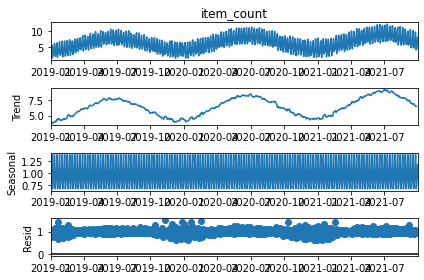

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean()

adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative', period=7) 

adjustment.plot()
pyplot.show()

Notice how the yearly seasonality was detected as the trend? The weekly seasonality was detected as seasonal. Without zooming you cannot see the ups and downs of the individual days of the week.

In [7]:
adjustment.trend

date
2019-01-01         NaN
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    3.920000
2019-01-05    3.672857
                ...   
2021-09-26    6.510000
2021-09-27    6.508571
2021-09-28         NaN
2021-09-29         NaN
2021-09-30         NaN
Name: trend, Length: 1004, dtype: float64

In [8]:
adjustment.seasonal

date
2019-01-01    0.793866
2019-01-02    0.889800
2019-01-03    1.177428
2019-01-04    1.378462
2019-01-05    1.380887
                ...   
2021-09-26    0.675276
2021-09-27    0.704281
2021-09-28    0.793866
2021-09-29    0.889800
2021-09-30    1.177428
Name: seasonal, Length: 1004, dtype: float64

In [9]:
fig = px.line(adjustment.trend)
fig.show()

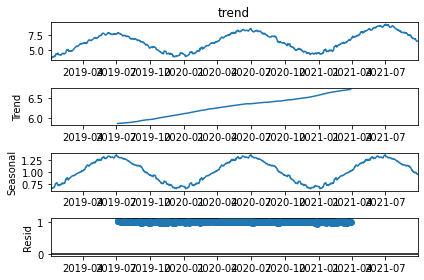

In [10]:
adjustment2 = seasonal_decompose(adjustment.trend.dropna(), model='multiplicative', period=365) 

adjustment2.plot()
pyplot.show()

In [11]:
fig = px.line(adjustment2.seasonal)
fig.show()

In [12]:
fig = px.line(adjustment2.trend)
fig.show()

In [13]:
from sklearn.linear_model import LinearRegression

X = np.arange(len(adjustment2.trend.dropna())).reshape(-1, 1)
y = adjustment2.trend.dropna().values

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9926800555026766

In [14]:
reg.coef_, reg.intercept_

(array([0.00129456]), 5.877286934924154)

## Resulting Dataset
Lets see the dataset "flattened".

In [15]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment2.seasonal / adjustment2.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [16]:
df_adjustment = pd.DataFrame()
df_adjustment['seasonal_week'] = adjustment.seasonal
df_adjustment['seasonal_year'] = adjustment2.seasonal
df_adjustment['trend'] = adjustment2.trend

df_adjustment

,seasonal_week,seasonal_year,trend
date,,,
2019-01-01,0.793866,NaN,NaN
2019-01-02,0.889800,NaN,NaN
2019-01-03,1.177428,NaN,NaN
2019-01-04,1.378462,0.697862,NaN
2019-01-05,1.380887,0.665845,NaN
...,...,...,...
2021-09-26,0.675276,0.960354,NaN
2021-09-27,0.704281,0.952361,NaN
2021-09-28,0.793866,NaN,NaN


In [17]:
for i in range(3):
    df_adjustment.iloc[i, 1] = df_adjustment.iloc[i+365, 1]
    df_adjustment.iloc[-1-i, 1] = df_adjustment.iloc[-1-i-365, 1]

df_adjustment[df_adjustment['seasonal_year'].isna()]

,seasonal_week,seasonal_year,trend
date,,,


In [18]:
df_adjustment['X'] = np.arange(-185, -185+df_adjustment.shape[0])

In [19]:
df_adjustment['trend_pred'] = reg.predict(df_adjustment['X'].values.reshape(-1, 1))

In [20]:
df_adjustment[df_adjustment['trend'].isna()]
#df_adjustment[~df_adjustment['trend'].isna()]

,seasonal_week,seasonal_year,trend,X,trend_pred
date,,,,,
2019-01-01,0.793866,0.698581,NaN,-185,5.637793
2019-01-02,0.889800,0.694851,NaN,-184,5.639087
2019-01-03,1.177428,0.698284,NaN,-183,5.640382
2019-01-04,1.378462,0.697862,NaN,-182,5.641677
2019-01-05,1.380887,0.665845,NaN,-181,5.642971
...,...,...,...,...,...
2021-09-26,0.675276,0.960354,NaN,814,6.931061
2021-09-27,0.704281,0.952361,NaN,815,6.932355
2021-09-28,0.793866,0.939799,NaN,816,6.933650


In [21]:
df_adjustment_forecast = pd.DataFrame(index=pd.date_range('2021-10-01','2021-12-31',freq='D'), )

df_adjustment_forecast['seasonal_week'] = df_adjustment.iloc[-7:,0].to_list()*13 + df_adjustment.iloc[-7:-6,0].to_list()
df_adjustment_forecast['seasonal_year'] = df_adjustment.iloc[-365:-365+92,1].to_list()
df_adjustment_forecast['trend'] = np.nan
df_adjustment_forecast['X'] = np.arange(819, 819+df_adjustment_forecast.shape[0])
df_adjustment_forecast['trend_pred'] = reg.predict(df_adjustment_forecast['X'].values.reshape(-1, 1))

df_adjustment_forecast

,seasonal_week,seasonal_year,trend,X,trend_pred
2021-10-01,1.378462,0.929211,NaN,819,6.937533
2021-10-02,1.380887,0.935133,NaN,820,6.938828
2021-10-03,0.675276,0.932019,NaN,821,6.940122
2021-10-04,0.704281,0.925891,NaN,822,6.941417
2021-10-05,0.793866,0.917464,NaN,823,6.942712
...,...,...,...,...,...
2021-12-27,0.704281,0.705666,NaN,906,7.050160
2021-12-28,0.793866,0.710213,NaN,907,7.051455
2021-12-29,0.889800,0.703822,NaN,908,7.052749
2021-12-30,1.177428,0.700695,NaN,909,7.054044


In [22]:
df_adjustment = pd.concat([df_adjustment, df_adjustment_forecast])

We will save the adjustment table to a binary pickle form, so we can later reload it exactly as it is. We will make use of this table during day 2.

In [23]:
df_sales_adj = df_sales.merge(df_adjustment[['seasonal_week', 'seasonal_year', 'trend_pred']],right_index=True,left_on='date')
df_sales_adj['adjust'] = df_sales_adj.sales / df_sales_adj.seasonal_week / df_sales_adj.seasonal_year / df_sales_adj.trend_pred

df_sales_adj

,date,item_id,price,sales,submit_id,seasonal_week,seasonal_year,trend_pred,adjust
0,2019-01-01,3,29.22,2.0,NaN,0.793866,0.698581,5.637793,0.639671
1,2019-01-01,4,26.42,22.0,NaN,0.793866,0.698581,5.637793,7.036383
2,2019-01-01,12,4.87,7.0,NaN,0.793866,0.698581,5.637793,2.238849
3,2019-01-01,13,4.18,12.0,NaN,0.793866,0.698581,5.637793,3.838027
4,2019-01-01,16,3.21,136.0,NaN,0.793866,0.698581,5.637793,43.497640
...,...,...,...,...,...,...,...,...,...
9195,2021-12-31,96,21.93,NaN,9195.0,1.378462,0.698581,7.055339,NaN
9196,2021-12-31,97,28.65,NaN,9196.0,1.378462,0.698581,7.055339,NaN
9197,2021-12-31,98,5.00,NaN,9197.0,1.378462,0.698581,7.055339,NaN
9198,2021-12-31,99,5.32,NaN,9198.0,1.378462,0.698581,7.055339,NaN


# Extract Data from Street Images with YOLO

In [24]:
import sys

!git clone https://github.com/ultralytics/yolov5 --tag 6.2  # clone
!mv /kaggle/working/6.2 /kaggle/working/yolov5
%pip install -qr /kaggle/working/yolov5/requirements.txt  # install
sys.path.insert(0,'/kaggle/working/yolov5/')

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.12 torch-1.11.0+cpu CPU


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 3964.5/4030.6 GB disk)


In [25]:
from os import walk
import datetime
import tqdm

# Model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom

filenames = next(walk(PATH_CAM), (None, None, []))[2]  

list_date = []
list_people_street = []
list_people_beach = []
x_cutoff = 800

for file in tqdm.tqdm(filenames):
    if file=='1.jpg': continue
    filename = os.path.join(PATH_CAM, file)
    results = yolo_model(filename)
    df = results.pandas().xyxy[0]
    people_street = len(df[(df.name=='person') & (df.xmin<x_cutoff)]) 
    people_beach = len(df[(df.name=='person') & (df.xmin>=x_cutoff)])
    dt = datetime.datetime.strptime(file[:10], '%Y_%m_%d')
    list_date.append(dt)
    list_people_street.append(people_street)
    list_people_beach.append(people_beach)

df_street_view = pd.DataFrame({'date':list_date,'people_street':list_people_street, 'people_beach':list_people_beach})
df_street_view

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.12 torch-1.11.0+cpu CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
100%|██████████| 1097/1097 [03:16<00:00,  5.58it/s]


,date,people_street,people_beach
0,2020-01-04,9,5
1,2019-07-15,13,5
2,2021-09-13,13,5
3,2021-06-15,14,6
4,2019-05-31,14,4
...,...,...,...
1091,2020-08-29,14,7
1092,2020-08-06,12,4
1093,2019-03-07,11,5
1094,2019-09-18,14,5


# Engineer Time Series Features

In [26]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def drop_columns(df, columns):
    columns_to_drop = [('%s(t+%d)' % (col, future_span)) for col in columns]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in columns]
    columns_to_drop += [('%s(t)' % col) for col in columns]
    df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

We will link the season and trend adjustments.

In [27]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales_adj.merge(df_items2,left_on='item_id',right_on='id')

df_train

,date,item_id,price,sales,submit_id,...,seasonal_year,trend_pred,adjust,id,store_id
0,2019-01-01,3,29.22,2.0,NaN,...,0.698581,5.637793,0.639671,3,1
1,2019-01-02,3,29.22,0.0,NaN,...,0.694851,5.639087,0.000000,3,1
2,2019-01-03,3,29.22,0.0,NaN,...,0.698284,5.640382,0.000000,3,1
3,2019-01-04,3,29.22,6.0,NaN,...,0.697862,5.641677,1.105550,3,1
4,2019-01-05,3,29.22,4.0,NaN,...,0.665845,5.642971,0.770940,3,1
...,...,...,...,...,...,...,...,...,...,...,...
109595,2021-12-27,100,2.48,NaN,8799.0,...,0.705666,7.050160,NaN,100,2
109596,2021-12-28,100,2.48,NaN,8899.0,...,0.710213,7.051455,NaN,100,2
109597,2021-12-29,100,2.48,NaN,8999.0,...,0.703822,7.052749,NaN,100,2
109598,2021-12-30,100,2.48,NaN,9099.0,...,0.700695,7.054044,NaN,100,2


In [28]:
# Merge people counts 
temp = len(df_train)
df_train = df_train.merge(df_street_view)
assert len(df_train) == temp

df_train

,date,item_id,price,sales,submit_id,...,adjust,id,store_id,people_street,people_beach
0,2019-01-01,3,29.22,2.0,NaN,...,0.639671,3,1,12,5
1,2019-01-01,4,26.42,22.0,NaN,...,7.036383,4,1,12,5
2,2019-01-01,12,4.87,7.0,NaN,...,2.238849,12,1,12,5
3,2019-01-01,13,4.18,12.0,NaN,...,3.838027,13,1,12,5
4,2019-01-01,16,3.21,136.0,NaN,...,43.497640,16,1,12,5
...,...,...,...,...,...,...,...,...,...,...,...
109595,2021-12-31,96,21.93,NaN,9195.0,...,NaN,96,5,12,6
109596,2021-12-31,97,28.65,NaN,9196.0,...,NaN,97,4,12,6
109597,2021-12-31,98,5.00,NaN,9197.0,...,NaN,98,2,12,6
109598,2021-12-31,99,5.32,NaN,9198.0,...,NaN,99,4,12,6


In [29]:
# Sort/agg
df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'adjust':['mean'],'sales':['mean'],'seasonal_week':['mean'],'seasonal_year':['mean'],'trend_pred':['mean'],'people_street':['mean'],'people_beach':['mean'],'submit_id':['mean']})
df_train.columns = ['item', 'store', 'date', 'adjust', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach', 'submit_id']
df_train.head()

,item,store,date,adjust,sales,...,seasonal_year,trend,people_street,people_beach,submit_id
0,1,4,2019-01-01,0.0,0.0,...,0.698581,5.637793,12.0,5.0,NaN
1,1,4,2019-01-02,0.0,0.0,...,0.694851,5.639087,11.0,5.0,NaN
2,1,4,2019-01-03,0.0,0.0,...,0.698284,5.640382,13.0,5.0,NaN
3,1,4,2019-01-04,0.0,0.0,...,0.697862,5.641677,10.0,6.0,NaN
4,1,4,2019-01-05,0.0,0.0,...,0.665845,5.642971,13.0,5.0,NaN


Lets also engineer two features. This gives the neural network some information about what day of the week and day of the year we are in. Ideally, these are not needed with seasonality generally removed; however, if some seasonality and trend remain, maybe these two features help the neural network to overcome.

In [30]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear

df_train

,item,store,date,adjust,sales,...,people_street,people_beach,submit_id,dow,doy
0,1,4,2019-01-01,0.0,0.0,...,12.0,5.0,NaN,1,1
1,1,4,2019-01-02,0.0,0.0,...,11.0,5.0,NaN,2,2
2,1,4,2019-01-03,0.0,0.0,...,13.0,5.0,NaN,3,3
3,1,4,2019-01-04,0.0,0.0,...,10.0,6.0,NaN,4,4
4,1,4,2019-01-05,0.0,0.0,...,13.0,5.0,NaN,5,5
...,...,...,...,...,...,...,...,...,...,...,...
109595,100,2,2021-12-27,NaN,NaN,...,7.0,4.0,8799.0,0,361
109596,100,2,2021-12-28,NaN,NaN,...,8.0,4.0,8899.0,1,362
109597,100,2,2021-12-29,NaN,NaN,...,8.0,6.0,8999.0,2,363
109598,100,2,2021-12-30,NaN,NaN,...,13.0,3.0,9099.0,3,364


Build the sequence data.

In [31]:
future_span = (df_sales_test['date'].max().date() - df_sales_train['date'].max().date()).days
print('Max date from train set: %s' % df_sales_train['date'].max().date())
print('Max date from test set: %s' % df_sales_test['date'].max().date())
print('Forecast lag size', future_span)

Max date from train set: 2021-09-30
Max date from test set: 2021-12-31
Forecast lag size 92


Remove sequences that did not have enough data.

In [32]:
window = 29
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span, dropnan=False)

# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
# last_dow = 'dow(t-%d)' % window
# last_doy = 'doy(t-%d)' % window

series = series[(series['store(t+%d)' % future_span] == series[last_store])]
series = series[(series['item(t+%d)' % future_span] == series[last_item])]

series

,item(t-29),store(t-29),adjust(t-29),sales(t-29),seasonal_week(t-29),...,people_street(t+92),people_beach(t+92),submit_id(t+92),dow(t+92),doy(t+92)
29,1.0,4.0,0.0,0.0,0.793866,...,15.0,6.0,NaN,3.0,122.0
30,1.0,4.0,0.0,0.0,0.889800,...,15.0,6.0,NaN,4.0,123.0
31,1.0,4.0,0.0,0.0,1.177428,...,12.0,7.0,NaN,5.0,124.0
32,1.0,4.0,0.0,0.0,1.378462,...,13.0,7.0,NaN,6.0,125.0
33,1.0,4.0,0.0,0.0,1.380887,...,11.0,5.0,NaN,0.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...
109503,100.0,2.0,0.0,0.0,1.380887,...,7.0,4.0,8799.0,0.0,361.0
109504,100.0,2.0,0.0,0.0,0.675276,...,8.0,4.0,8899.0,1.0,362.0
109505,100.0,2.0,0.0,0.0,0.704281,...,8.0,6.0,8999.0,2.0,363.0
109506,100.0,2.0,0.0,0.0,0.793866,...,13.0,3.0,9099.0,3.0,364.0


We will predict with adjusted sales, and our engineered features.

In [33]:
labels_col = 'adjust(t+%d)' % future_span
submit_id_col = 'submit_id(t+%d)' % future_span

series_train = series.loc[series[submit_id_col].isna()].copy(deep=True)
series_submit = series.loc[~series[submit_id_col].isna()].copy(deep=True)

print(series_train.shape, series_submit.shape)

(88300, 372) (9200, 372)


In [34]:
# Label
labels = series_train[labels_col]
series_train.drop(labels_col, axis=1, inplace=True)
series_train.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('doy(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('people_street(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('people_beach(t+%d)' % future_span, axis=1, inplace=True)
series_train.drop('submit_id(t+%d)' % future_span, axis=1, inplace=True)

# store the seasonal and trend
unadjust_sales_col = 'sales(t+%d)' % future_span
seasonal_week_col = 'seasonal_week(t+%d)' % future_span
seasonal_year_col = 'seasonal_year(t+%d)' % future_span
trend_col = 'trend(t+%d)' % future_span

hold_sales = series_train[unadjust_sales_col]
hold_seasonal_week = series_train[seasonal_week_col]
hold_seasonal_year = series_train[seasonal_year_col]
hold_trend = series_train[trend_col]

series_train.drop(unadjust_sales_col, axis=1, inplace=True)
series_train.drop(seasonal_week_col, axis=1, inplace=True)
series_train.drop(seasonal_year_col, axis=1, inplace=True)
series_train.drop(trend_col, axis=1, inplace=True)

series_train

,item(t-29),store(t-29),adjust(t-29),sales(t-29),seasonal_week(t-29),...,people_street(t),people_beach(t),submit_id(t),dow(t),doy(t)
29,1.0,4.0,0.0,0.0,0.793866,...,10.0,5.0,NaN,2,30
30,1.0,4.0,0.0,0.0,0.889800,...,11.0,6.0,NaN,3,31
31,1.0,4.0,0.0,0.0,1.177428,...,12.0,6.0,NaN,4,32
32,1.0,4.0,0.0,0.0,1.378462,...,13.0,6.0,NaN,5,33
33,1.0,4.0,0.0,0.0,1.380887,...,9.0,6.0,NaN,6,34
...,...,...,...,...,...,...,...,...,...,...,...
109411,100.0,2.0,0.0,0.0,1.378462,...,14.0,5.0,NaN,5,177
109412,100.0,2.0,0.0,0.0,1.380887,...,13.0,6.0,NaN,6,178
109413,100.0,2.0,0.0,0.0,0.675276,...,11.0,4.0,NaN,0,179
109414,100.0,2.0,0.0,0.0,0.704281,...,13.0,5.0,NaN,1,180


In [35]:
# Get adjust sales sequences
series2 = series_train.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
sales_series = series2.values

# Day of week as a number
series2 = series_train.copy()
drop_columns(series2, ['item','store','adjust', 'doy', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
dow_series = series2.values

# Get day of year sequences
series2 = series_train.copy()
drop_columns(series2, ['item','store','dow', 'adjust', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
doy_series = series2.values

# Get number of people sequences
series2 = series_train.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'adjust', 'people_beach', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend'])
people_street_series = series2.values

series2 = series_train.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'adjust', 'people_street', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend'])
people_beach_series = series2.values

# Create x
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
t4 = people_street_series.reshape(people_street_series.shape + (1,))
t5 = people_beach_series.reshape(people_beach_series.shape + (1,))
x1 = np.concatenate([t1,t2,t3,t4,t5],axis=2)

Double check that all input data is of the same shape.

In [36]:
print(t1.shape)
print(t2.shape)
print(t3.shape)
print(t4.shape)
print(t5.shape)

(88300, 30, 1)
(88300, 30, 1)
(88300, 30, 1)
(88300, 30, 1)
(88300, 30, 1)


# Vectorize Item Names with Glove Embeddings

In [37]:
!wget -c "https://nlp.stanford.edu/data/glove.6B.zip"
!unzip glove.6B.zip

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.6B.300d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
w2vec_model = KeyedVectors.load_word2vec_format(tmp_file)

--2022-11-29 21:49:51--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-29 21:49:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.99MB/s    in 2m 40s  

2022-11-29 21:52:31 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).



In [38]:
def process_title(model, name):
    v = None
    i = 0
    for word in name.split(' '):
        word = word.lower()
        if word == 'vegi': 
            word = "vegetable"
        if word == 'smoothy': 
            word = "malt"
        i+=1
        if v is None and word in model:
            v=model[word].copy()
        elif word in model:
            v+=model[word]
    v/=i
    return v

In [39]:
item_lookup = {}
for i, name in zip(list(df_items.id),list(df_items.name)):
    v = process_title(w2vec_model,name)
    item_lookup[i] = v

In [40]:
# Create predictors (x)
vec_size = w2vec_model['test'].shape[0]

lst = []
for item in list(series_train['item(t-1)']):
    lst.append(item_lookup[item])

x2 = np.concatenate(lst).reshape((series_train.shape[0],vec_size))

x = [x1,x2]

In [41]:
print(x1.shape, x2.shape)

(88300, 30, 5) (88300, 300)


# Train the Network

Extract the predictors (x sequences) and the label (future prediction)

In [42]:
TEST_SIZE = 0.4

mask = np.random.random(size=x[0].shape[0]) < TEST_SIZE

X_train = []
X_valid = []

for subx in x:
    X_train.append(subx[~mask])
    X_valid.append(subx[mask])

Y_train = labels.values[~mask]
Y_valid = labels.values[mask]

print('Train set shape x1:', X_train[0].shape)
print('Train set shape x2:', X_train[1].shape)
print('Validation set shape x1:', X_valid[0].shape)
print('Validation set shape x2:', X_valid[1].shape)

Train set shape x1: (53142, 30, 5)
Train set shape x2: (53142, 300)
Validation set shape x1: (35158, 30, 5)
Validation set shape x2: (35158, 300)


In [43]:
Y_train_seasonal_week = hold_seasonal_week.values[~mask]
Y_valid_seasnoal_week = hold_seasonal_week.values[mask]

Y_train_seasonal_year = hold_seasonal_year.values[~mask]
Y_valid_seasnoal_year = hold_seasonal_year.values[mask]

Y_train_trend = hold_trend.values[~mask]
Y_valid_trend = hold_trend.values[mask]

Construct the neural network.

In [44]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, concatenate, Input
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()

A1 = Input(shape=(X_train[0].shape[1], X_train[0].shape[2]),name='A1')
A2 = Conv1D(filters=64, kernel_size=8, activation='relu')(A1)
A3 = MaxPooling1D(pool_size=2)(A2)
A4 = Flatten()(A3)
A5 = Dense(50, activation='relu')(A4)
A6 = Dropout(0.2)(A5)

B1 = Input(shape=X_train[1].shape[1],name='B1')
B2 = Dense(16, activation='relu',name='B2')(B1)

M1 = concatenate([A6,B2])
M2 = Dense(1,name='M2')(M1)

model = Model(inputs=[A1, B1],outputs=[M2])
model.compile(loss='mse', optimizer=adam)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A1 (InputLayer)                 [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 23, 64)       2624        A1[0][0]                         
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 11, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 704)          0           max_pooling1d[0][0]              
______________________________________________________________________________________________

2022-11-29 21:56:25.434148: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Fit the neural network.

In [45]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(X_train, Y_train, callbacks=[monitor],
    validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

2022-11-29 21:56:26.444153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
1661/1661 - 8s - loss: 11.9866 - val_loss: 2.3027
Epoch 2/500
1661/1661 - 7s - loss: 2.8727 - val_loss: 2.6605
Epoch 3/500
1661/1661 - 7s - loss: 2.7808 - val_loss: 1.9611
Epoch 4/500
1661/1661 - 7s - loss: 2.8751 - val_loss: 2.0936
Epoch 5/500
1661/1661 - 6s - loss: 2.6019 - val_loss: 2.0058
Epoch 6/500
1661/1661 - 6s - loss: 2.5772 - val_loss: 1.9334
Epoch 7/500
1661/1661 - 8s - loss: 2.4701 - val_loss: 1.9535
Epoch 8/500
1661/1661 - 6s - loss: 2.5529 - val_loss: 2.0170
Epoch 9/500
1661/1661 - 6s - loss: 2.5142 - val_loss: 1.9190
Epoch 10/500
1661/1661 - 6s - loss: 2.5706 - val_loss: 1.9381
Epoch 11/500
1661/1661 - 7s - loss: 2.4634 - val_loss: 1.9579
Epoch 12/500
1661/1661 - 7s - loss: 2.4146 - val_loss: 2.0936
Epoch 13/500
1661/1661 - 8s - loss: 2.3937 - val_loss: 2.0270
Epoch 14/500
1661/1661 - 7s - loss: 2.3352 - val_loss: 1.9615
Epoch 15/500
1661/1661 - 6s - loss: 2.3740 - val_loss: 1.8849
Epoch 16/500
1661/1661 - 7s - loss: 2.2986 - val_loss: 2.0165
Epoch 17/500
166

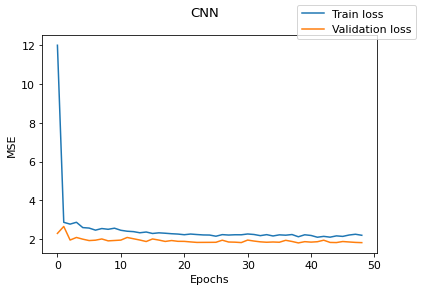

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

In [47]:
from sklearn.metrics import mean_squared_error 

cnn_train_pred = model.predict(X_train) 
cnn_valid_pred = model.predict(X_valid) 
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred))) 
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 1.3538645512695184
Validation rmse: 1.346480359182885


In [48]:
Y_train_actual = hold_sales.values[~mask]
Y_valid_actual = hold_sales.values[mask]

cnn_train_pred2 = cnn_train_pred.flatten() * Y_train_seasonal_week * Y_train_seasonal_year * Y_train_trend
cnn_valid_pred2 = cnn_valid_pred.flatten() * Y_valid_seasnoal_week * Y_valid_seasnoal_year * Y_valid_trend

print('Train rmse:', np.sqrt(mean_squared_error(Y_train_actual, cnn_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_actual, cnn_valid_pred2)))

Train rmse: 10.002409013761275
Validation rmse: 9.212799179925852


# Build a Submission File

In [49]:
submit_id = series_submit[submit_id_col].astype(int)

series_submit.drop(labels_col, axis=1, inplace=True)
series_submit.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('doy(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('people_street(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('people_beach(t+%d)' % future_span, axis=1, inplace=True)
series_submit.drop('submit_id(t+%d)' % future_span, axis=1, inplace=True)

# store the seasonal and trend
#hold_sales_submit = series_submit[unadjust_sales_col]
hold_seasonal_week_submit = series_submit[seasonal_week_col]
hold_seasonal_year_submit = series_submit[seasonal_year_col]
hold_trend_submit = series_submit[trend_col]

series_submit.drop(unadjust_sales_col, axis=1, inplace=True)
series_submit.drop(seasonal_week_col, axis=1, inplace=True)
series_submit.drop(seasonal_year_col, axis=1, inplace=True)
series_submit.drop(trend_col, axis=1, inplace=True)

series_submit

,item(t-29),store(t-29),adjust(t-29),sales(t-29),seasonal_week(t-29),...,people_street(t),people_beach(t),submit_id(t),dow(t),doy(t)
912,1.0,4.0,0.0,0.0,0.889800,...,12.0,7.0,NaN,3,182
913,1.0,4.0,0.0,0.0,1.177428,...,15.0,7.0,NaN,4,183
914,1.0,4.0,0.0,0.0,1.378462,...,15.0,5.0,NaN,5,184
915,1.0,4.0,0.0,0.0,1.380887,...,11.0,6.0,NaN,6,185
916,1.0,4.0,0.0,0.0,0.675276,...,14.0,6.0,NaN,0,186
...,...,...,...,...,...,...,...,...,...,...,...
109503,100.0,2.0,0.0,0.0,1.380887,...,13.0,3.0,NaN,6,269
109504,100.0,2.0,0.0,0.0,0.675276,...,9.0,4.0,NaN,0,270
109505,100.0,2.0,0.0,0.0,0.704281,...,11.0,3.0,NaN,1,271
109506,100.0,2.0,0.0,0.0,0.793866,...,15.0,4.0,NaN,2,272


In [50]:
# Get sales sequences
series2 = series_submit.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
sales_series = series2.values

# Day of week as a number
series2 = series_submit.copy()
drop_columns(series2, ['item','store','adjust', 'doy', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
dow_series = series2.values

# Get day of year sequences
series2 = series_submit.copy()
drop_columns(series2, ['item','store','dow', 'adjust', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend', 'people_street', 'people_beach'])
doy_series = series2.values

# Get number of people sequences
series2 = series_submit.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'adjust', 'people_beach', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend'])
people_street_series = series2.values

series2 = series_submit.copy()
drop_columns(series2, ['item','store','dow', 'doy', 'adjust', 'people_street', 'submit_id', 'sales', 'seasonal_week', 'seasonal_year', 'trend'])
people_beach_series = series2.values


# Create x
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
t4 = people_street_series.reshape(people_street_series.shape + (1,))
t5 = people_beach_series.reshape(people_beach_series.shape + (1,))
x1 = np.concatenate([t1,t2,t3,t4,t5],axis=2)

In [51]:
print(t1.shape)
print(t2.shape)
print(t3.shape)
print(t4.shape)
print(t5.shape)

(9200, 30, 1)
(9200, 30, 1)
(9200, 30, 1)
(9200, 30, 1)
(9200, 30, 1)


In [52]:
# Create predictors (x)
vec_size = w2vec_model['test'].shape[0]

lst = []
for item in list(series_submit['item(t-1)']):
    lst.append(item_lookup[item])

x2 = np.concatenate(lst).reshape((series_submit.shape[0],vec_size))

x_submit = [x1,x2]

In [53]:
submit_pred = model.predict(x_submit)

In [54]:
submit_pred = submit_pred.flatten() * hold_seasonal_week_submit.values * hold_seasonal_year_submit.values * hold_trend_submit.values

In [55]:
df_submit = pd.DataFrame()
df_submit['id'] = submit_id.to_list()
df_submit['item_count'] = submit_pred

In [56]:
df_submit.item_count[df_submit['item_count']<0] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
df_submit.to_csv('submission.csv',index=False)